In [ ]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.
This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.
"""
from omegaconf import OmegaConf

def load_dataset(config: OmegaConf):
    from hydra.utils import instantiate
    dataset = instantiate(config.datamodule)
    dataset.prepare_data()
    dataset.setup()
    return dataset

In [4]:
# make new omegaconf
config10 = OmegaConf.create({
    "datamodule": {
        "_target_": "recipe.datasets.astarmaze.AstarMazeDataset",
        "batch_size": 32,
        "num_workers": 8,
        "return_prediction_mask": True,
        "grid_n": 10,
        "n_mazes": 100
    }
})
config20 = config10.copy()
config20.datamodule.grid_n = 20
config30 = config10.copy()
config30.datamodule.grid_n = 30

ds10 = load_dataset(config10)
ds20 = load_dataset(config20)
ds30 = load_dataset(config30)

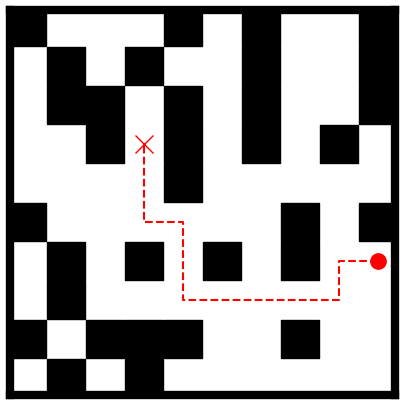

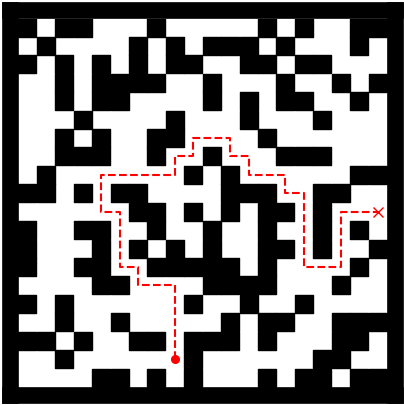

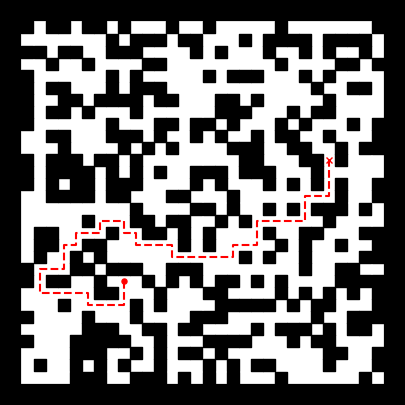

In [23]:
# make this into a grid representation
def get_walls(grid_tokens):
    walls = []
    for i,tok in enumerate(grid_tokens):
        if tok == "wall":
            # get the x, y coordinates
            x = int(grid_tokens[i+1])
            y = int(grid_tokens[i+2])
            walls.append((x, y))
    return walls

def get_node(grid_tokens, name):
    for i,tok in enumerate(grid_tokens):
        if tok == name:
            # get the x, y coordinates
            x = int(grid_tokens[i+1])
            y = int(grid_tokens[i+2])
            return (x, y)
    raise ValueError(f"No {name} found")

def get_plan(grid_tokens):
    plan = []
    for i,tok in enumerate(grid_tokens):
        if tok == "plan":
            # get the x, y coordinates
            x = int(grid_tokens[i+1])
            y = int(grid_tokens[i+2])
            plan.append((x, y))
    return plan

def plot_maze(grid_tokens, grid_size):
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch
    walls = get_walls(grid_tokens)
    plan = get_plan(grid_tokens)
    start = get_node(grid_tokens, "start")
    goal = get_node(grid_tokens, "goal")
    plt.figure(figsize=(5, 5))
    if grid_size == 10:
        marker_size = 730
        mutation_scale = 20
        spine_width = 6
    elif grid_size == 20:
        marker_size = 182
        mutation_scale = 10
        spine_width = 12
    elif grid_size == 30:
        marker_size = 79
        mutation_scale = 4
        spine_width = 16

    plt.scatter(*start, c="r", s=marker_size/6)
    plt.plot(*goal, "x", c="r", markersize=marker_size**.5/2)
    
    for wall in walls:
        plt.scatter(*wall, c="k", s=marker_size, marker="s")
    plt.plot(*zip(*plan), '--', c="r")
    # for s,e in zip(plan[:-1], plan[1:]):
    #     arrow = FancyArrowPatch(s, e, arrowstyle='-|>', mutation_scale=mutation_scale, color="b")
    #     plt.gca().add_patch(arrow)
        # plt.arrow(*s, e[0]-s[0], e[1]-s[1], head_width=0.5, head_length=0.5, fc='b', ec='b')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])
    for spine in plt.gca().spines.values():
      spine.set_linewidth(spine_width)

    plt.savefig(f"figures/{grid_size}x{grid_size}_astarmaze.pdf", bbox_inches="tight", pad_inches=0)

for ds in [ds10, ds20, ds30]:
    import torch
    torch.manual_seed(42)
    batch = next(iter(ds.train_dataloader()))
    grid_repr = ds.tokenizer.decode(batch["input_ids"][0].tolist())
    plot_maze(grid_repr, ds.grid_n)